# HD 189733 b <a id='top'></a>
### This contains many of the same steps as the Quickstart, but takes longer to run. 
Does not include ramping to HD189733's XUV stellar spectrum as of 2024-7-7.

**Note:** Units are cgs unless otherwise specified. It is not necessary to use Astropy units.

**Reminder: Relaxation codes are inherently finicky! Have patience and try ramping parameters in different orders or taking smaller steps in parameter space if the solver gets stuck.**

In [1]:
from wind_ae.wrapper.relax_wrapper import wind_simulation as wind_sim
from wind_ae.wrapper.wrapper_utils.plots import *
from wind_ae.wrapper.wrapper_utils import constants as const
from wind_ae.wrapper.wrapper_utils.system import system
from wind_ae.wrapper.wrapper_utils.spectrum import spectrum
import wind_ae.McAstro.atoms.atomic_species as McAtom

## 1. [Ramping to a new planet](#newplanet) 
- [Loading initial guess](#loadguess)
- [Ramping to planet](#newplanet2)
- [Interacting with solution outputs](#windsoln)
- [Mass Loss rate ($\dot{M}$)](#Mdot)
- [Plotting](#plot)
- [Saving solutions](#save)
    - [Advanced: Lowering lower boundary](#bcs)

## 2. [Ramping stellar spectrum](#spectrum) 
- [Ramping wavelength range and flux](#range)
- [Ramping to custom spectrum](#custom)

## 3. [Adding Metals](#metals)
- [Adding metals](#metals)
- [Ramping metallicity](#metallicity)

## 4. [Easy output file](#output)

## 1. Ramping to a new planet <a id='newplanet'></a>
### Load Initial Guess <a id='loadguess'></a>
Load initial guess from which the relaxation code will ramp to your desired parameters. `calc_postfacto=True` takes the time to compute all of the post-facto variables. Post facto calculations are not necessary to run the ramping.

**Note:** `sim.load_planet('saves/filename')` will load the guess parameters into the input files in `Inputs/` and may interrupt ongoing runs of the relaxation code. To do computations with or plot a solution without overwriting the `Inputs/` files, use `sim.load_uservars('saves/filename')`.

In [2]:
sim = wind_sim()
sim.load_planet('../wind_ae/saves/HD209458b/HD209_13.6-2000eV_H-He.csv',calc_postfacto=True)
sim.system.print_system()

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
Loaded Planet:
  System parameters (cgs)               # Normalized units
    Mp:        1.330000e+30 g           #     0.70 MJ
    Rp:        1.000000e+10 cm          #     1.40 RJ
    Mstar:     1.988416e+33 g           #     1.00 Msun
    semimajor: 7.480000e+11 cm          #     0.05 au
    Ftot:      1.095713e+03 erg/cm^2/s  # 2.35e+02 FuvEarth
    Lstar:     6.807420e+33 erg/s       # 1.78e+00 Lsun



#### To run relaxation code (NOT necessary for ramping)
To run relaxation code for whatever solution is loaded into the `Inputs/` files, run `sim.run_wind()` which returns 0 if successful.

Any time a simulation is run through the python wrapper, the solution generated at each step is saved in `'saves/windsoln.csv'` and the solution is copied into `'Inputs/guess.inp'` to be the guess for for the next iteration.

### Ramping to "new planet" <a id='newplanet2'></a>        -         [Top](#top)

New planets can be created by supplying a planetary mass ($M_\mathrm{p}$), planetary radius ($R_\mathrm{p}$), stellar mass ($M_\star$), semimajor-axis ($a$), stellar *bolometric* luminosity ($L_\star$) and the total integrated ionizing flux ($F_\mathrm{tot}$) to the `system` object.


To run relaxation code for whatever solution is loaded into the `Inputs/` files, run `sim.run_wind()` which returns `0` if successful.

A ramping output of `5` also means that it ramped successfully, but that one or more of the polishing steps could not be completed. Effects on mass loss rates and wind structure are minimal, but confirm that the result is acceptable by plotting the `energy_plot` and `six_panel_plot` or `quick_plot`.

**Helpful Hint**: Take advantage of the McAstro cgs constants object (`const`). These do not contain units and no functions accept astropy units.

In [3]:
HD189733b = system(1.162*const.Mjupiter, 1.138*const.Rjupiter,
                   0.846*const.Msun, 0.031*const.au, 
                   24170,0.328*const.Lsun,
                   name='HD 189733 b') 

HD189733b.print_system(norm='Jupiter')

HD 189733 b:
  System parameters (cgs)               # Normalized units
    Mp:        2.206084e+30 g           #     1.16 MJ
    Rp:        8.135790e+09 cm          #     1.14 RJ
    Mstar:     1.682200e+33 g           #     0.85 Msun
    semimajor: 4.637600e+11 cm          #     0.03 au
    Ftot:      2.417000e+04 erg/cm^2/s  # 5.18e+03 FuvEarth
    Lstar:     1.255584e+33 erg/s       # 3.28e-01 Lsun



In [4]:
%%time
#Est. runtime: 6 min 
sim.ramp_to(system=HD189733b,intermediate_converge=True,integrate_out=True) #integrates past sonic point using ODE solver
#to avoid the expense of polishing BCs after every parameter is ramped, can set intermediate_converge=False; 
#however, ramping has a chance of failing

Ramping Ftot from 1.096e+03 to 2.417e+04.                                                     
  Final:  Ftot:2.417000e+04, delta:2.363                                                                      
Polishing up boundary conditions...
Ramping Mp from 1.330e+30 to 2.206e+30 g AND Rp from 1.000e+10 to 8.136e+09 cm.                                                              
...Intermediate Ramping BCs activated.2e+09, M_delta:0.0025                                               
..Turning off bolometric heating/cooling.
  Final:  Mp:2.206084e+30 & Rp:8.135790e+09, M_delta:0.009181                                                                                                                                                                     
Polishing up boundary conditions...
Successfully ramped base boundary conditions.                                                           NOTE: Photoionization heating dominates down to base of sim (1.029 Rp).                             

0

### Solution outputs (windsoln object) <a id='windsoln'></a>
To interact with wind solution object, use `sim.windsoln`.
- Dependent variables returned by the relaxation code: `'r'`,`'v'`,`'T'`,`'rho'`, `'Ys_[species]'`, `'Ncol_[species]'`, `E`, etc.

- Dependent variables calculated post facto by running `sim.windsoln.add_user_vars()` or loading solution from save file as `sim.load_uservars('saves/filename')`: `'mu'`,`'heat_ion'` (etc.), . See below.

- Parameters of the solution: `sim.windsoln.Rp`,`sim.windsoln.E_wl`, `sim.windsoln.Ys_rmin`, `sim.windsoln.species_list`, etc.

- Tuples of the solution parameters: `sim.windsoln.planet_tuple`,`sim.windsoln.bcs_tuple`, etc.

In [5]:
sim.windsoln.add_user_vars()
sim.windsoln.soln.columns

         Wind-AE does not currently model conductive cooling.


Index(['r', 'rho', 'v', 'T', 'Ys_HI', 'Ys_HeI', 'Ncol_HI', 'Ncol_HeI', 'q',
       'z', 'n_e', 'n_H', 'n_HI', 'n_HII', 'n_He', 'n_HeI', 'n_HeII', 'n_tot',
       'mu', 'P', 'ram', 'cs', 'Mach', 'Hsc', 'heat_ion', 'ionization_HI',
       'ionization_HeI', 'euv_ionization_HI', 'euv_ionization_HeI',
       'heating_HI', 'heating_HeI', 'tau_ion_HI', 'tau_ion_HeI', 'ion_eq_HI',
       'ion_eq_HeI', 'DlnP', 'mfp_hb', 'mfp_Co', 'mfp_mx', 'Kn_hb_HI',
       'Kn_Co_HI', 'Kn_mx_HI', 'recomb_HI', 'recomb_HeI', 'cool_lyman',
       'cool_PdV', 'cool_cond', 'cool_rec', 'boloheat', 'bolocool',
       'cool_grav', 'e_therm', 'heat_advect', 'cum_heat', 'sp_kinetic',
       'sp_enthalpy', 'sp_grav', 'bern_rogue', 'bern_isen', 'bern', 'ad_prof',
       'static_prof', 'static_rho', 'static_P', 'static_T', 'del_ad',
       'Gamma_2', 'Gamma_3'],
      dtype='object')

### Get Mass Loss Rate <a id='Mdot'></a>
To account for geometric and circulation effects, the substellar $\dot{M}$ is multiplied by a factor of 0.33 in the post-facto calculations in the python wrapper.

Given the uncertainties inherent in 1D modeling of mass loss, $\dot{M}$ differences of a few to a few tens of percent difference are negligible.

In [5]:
Mdot = sim.windsoln.Mdot
print(f"Mass loss rate of {Mdot:.3e} g/s")

Mass loss rate of 1.055e+10 g/s


### Plot <a id='plot'></a>        -         [Top](#top)

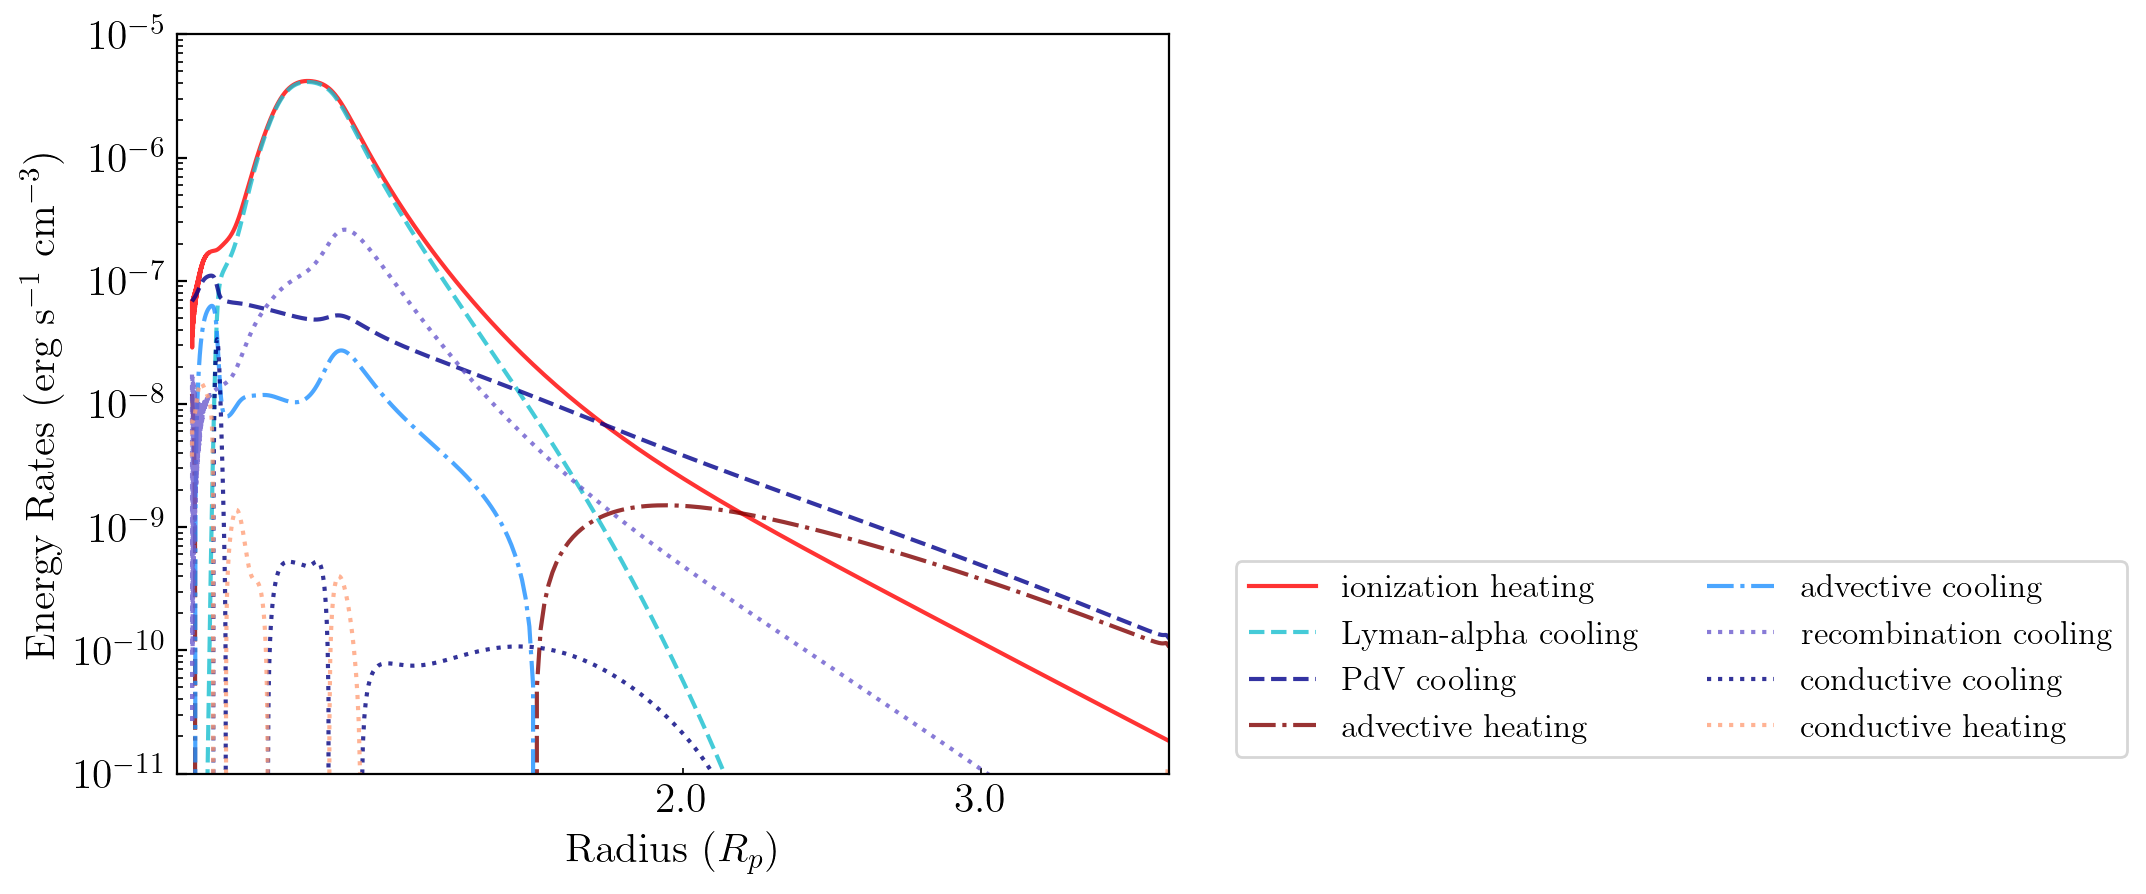

In [5]:
energy_plot(sim.windsoln,all_terms=True) 
#notice how this is high flux, so Ly-alpha cooling is significant!

         Wind-AE does not currently model conductive cooling.
***** HD 209548b: Mdot = 1.97e+10 g/s *****
***** HD 189733b: Mdot = 1.05e+10 g/s *****


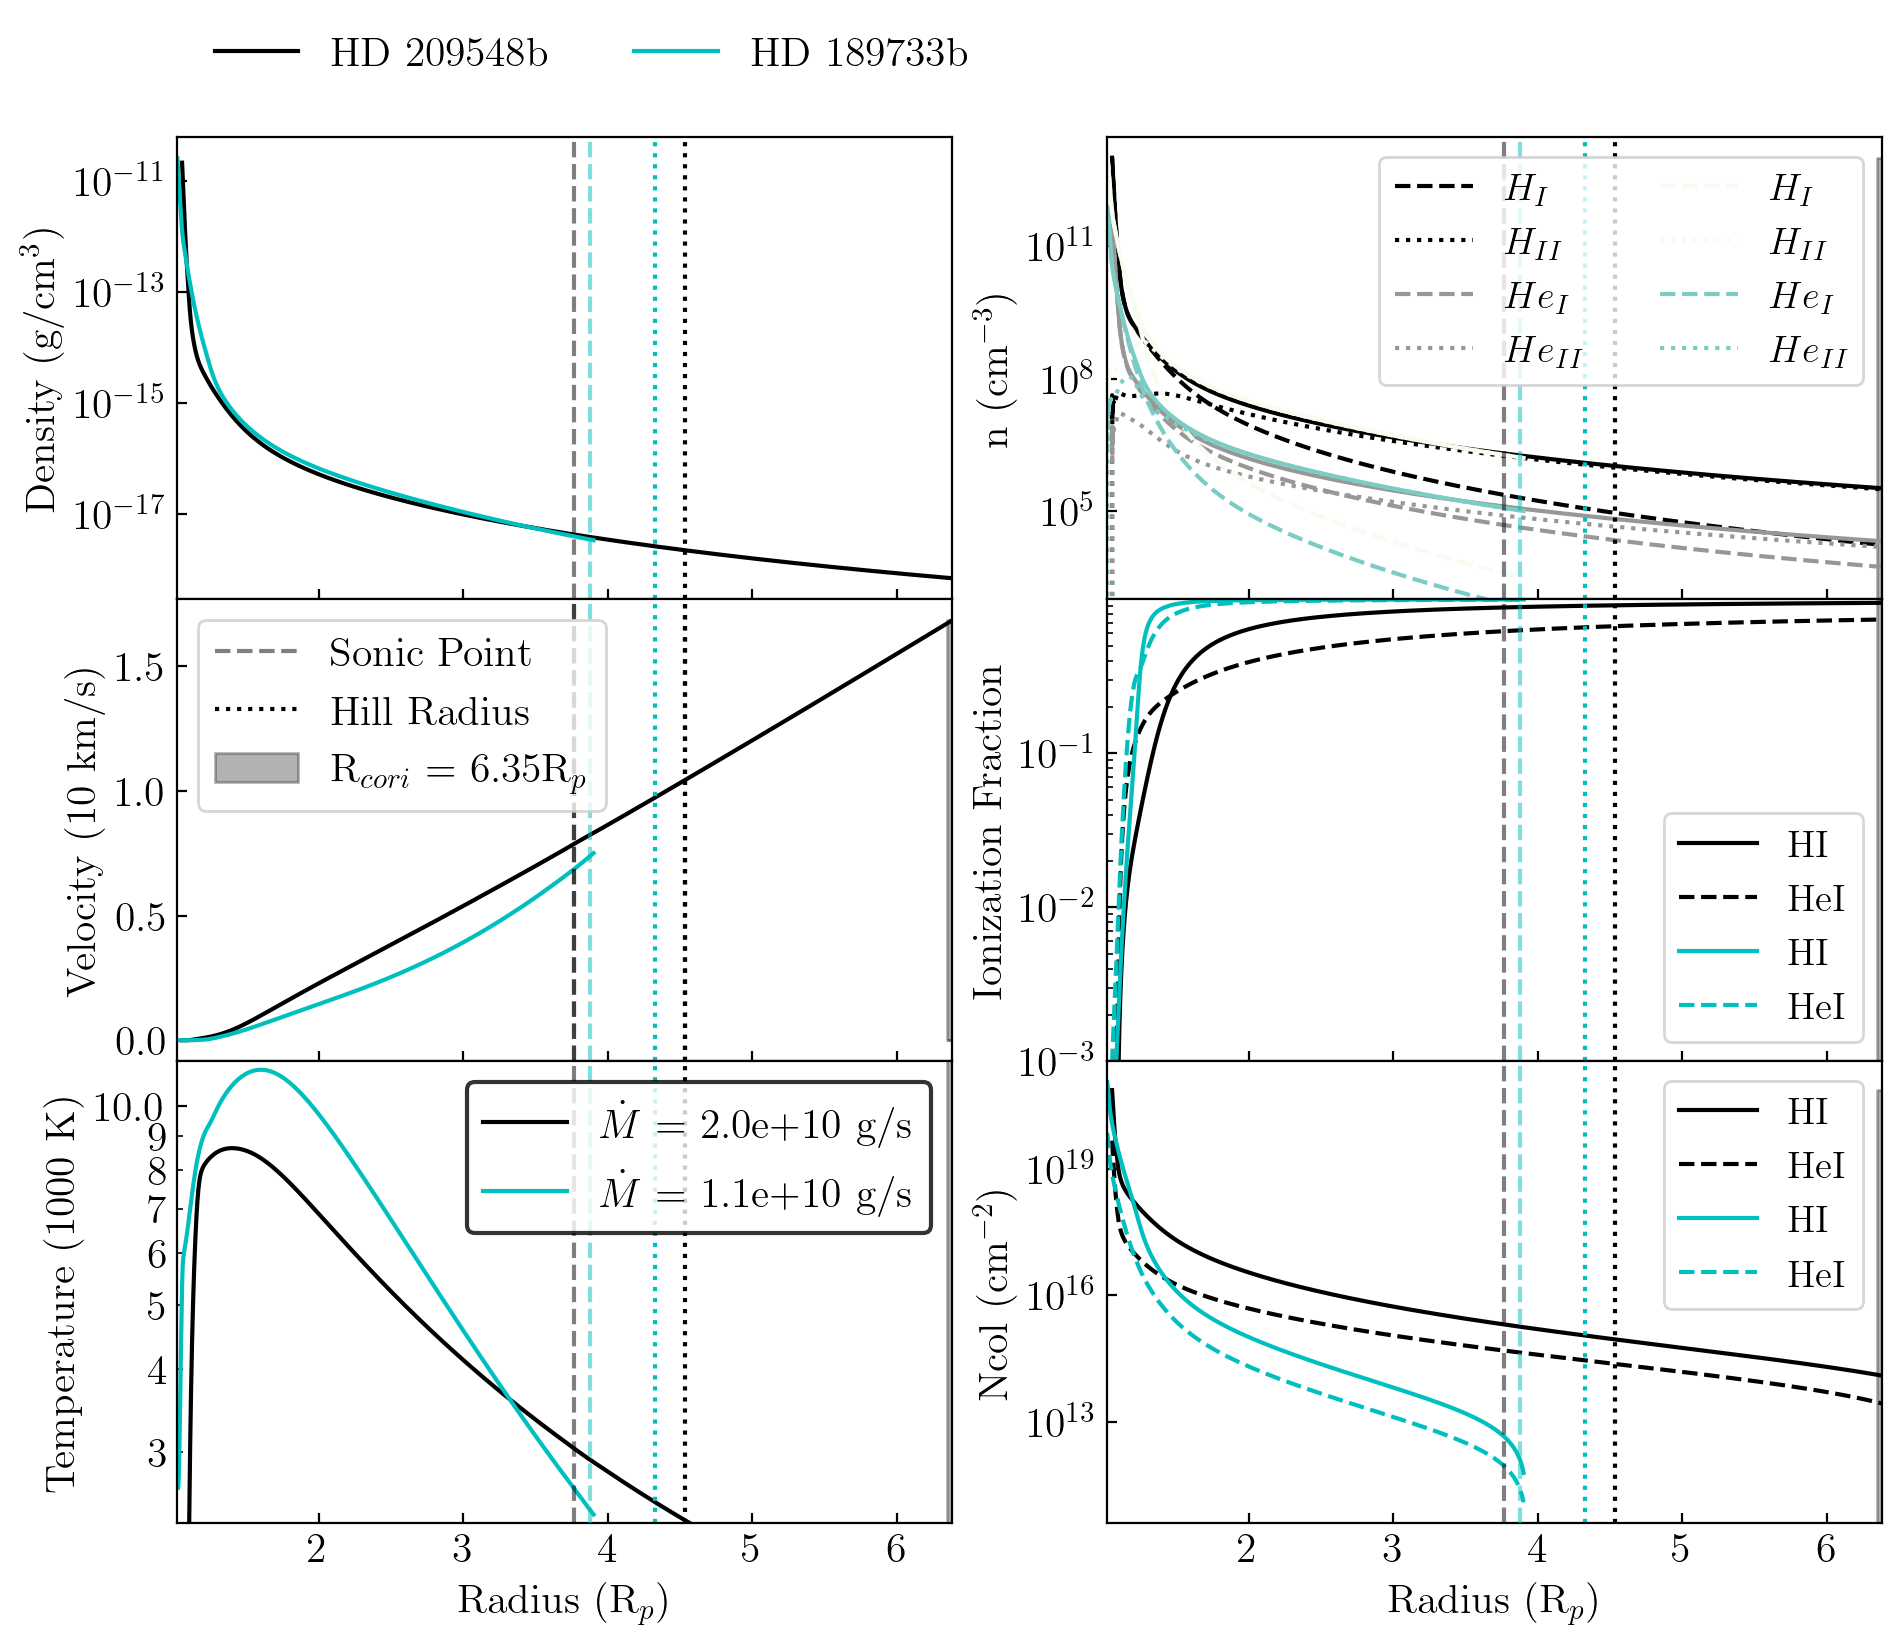

In [8]:
#Compare to an existing solution
#load JUST the post-facto calculations from an existing solution
sim_HD209 = wind_sim()
sim_HD209.load_uservars('../wind_ae/saves/HD209458b/HD209_13.6-2000eV_H-He.csv')

#perform the post-facto calculations for the planet currently in the windsoln object, HD189733 b
sim.windsoln.add_user_vars() 
#run the following line instead if you did not ramp to HD 189733b in the prior cells:
# sim.load_uservars('saves/HD189733b/HD189733b_13.6-2000eV_solar_H-He.csv') 
#alternatives: sim.load_uservars('saves/windsoln.csv'), sim.load_planet('saves/windsoln.csv',calc_postfacto=True)

#To plot comparisons
ax = six_panel_plot(sim_HD209.windsoln,
                    label='HD 209548b',c='k')
six_panel_plot(sim.windsoln,
               first_plotted=False,ax=ax,
               label='HD 189733b',c='c')
plt.show()

### Save Planet <a id='save'></a>

In [9]:
sim.save_planet('saves/HD189733b/HD189733b_13.6-2000eV_solar_H-He.csv',overwrite=True)

Saving saves/HD189733b/HD189733b_13.6-2000eV_solar_H-He.csv


#### Advanced: Lowering lower BCs to capture all photoionization heating
Note that in this particular example, we received the warning `Bolometric heat/cooling still turned off. Max error in dM/dt ~ 10%. 
 See documentation for workaround.` and we can see that photoionization heating dominates over PdV cooling at the base of the simulation in the energy plot. This means we may be slightly underestimating the mass loss rates (though still well within the error expectations of $\dot{M}$ in our model).
 
 We can attempt to lower the lower BCs of the simulation to capture the highest energy photons.

**Note:** Scaleheights are small at these radii, so, using our scheme of physically computed lower BCs (see, Broome et al. in prep) lowering the pressure of the base will not move $R_{min}$ much deeper into the atmosphere. It is possible to set one's own lower BCs and maintain these during ramping/polishing by setting `static_bcs=True`.

**Warning:** This calculation is expensive (~10 minutes) and difference in $\dot{M}$ is well within the error bounds of `Wind-AE`'s $\dot{M}$ estimate. However, future ramps will maintain this higher pressure lower boundary condition, so it is a one-time cost.

In [11]:
#Est. runtime: 17 min
sim.load_planet('saves/HD189733b/HD189733b_13.6-2000eV_solar_H-He.csv')
sim.ramp_base_bcs(base_press=10,user_override_press=True) #in units of microbars

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
Attempting to ramp Rmin:1.02->1.02Rp, rho:2.566e-11->2.566e-10g/cm3, T:1277->1277K                                                                                                                                                ..Initial jump failed. Ramping variables individually.
   Successfully converged Rmin to 1.017566 Rp.ng 1.0176                                                                                           
Successfully ramped base boundary conditions.                                                                                            

0

Mass loss rate is now 1.00e+09 g/s


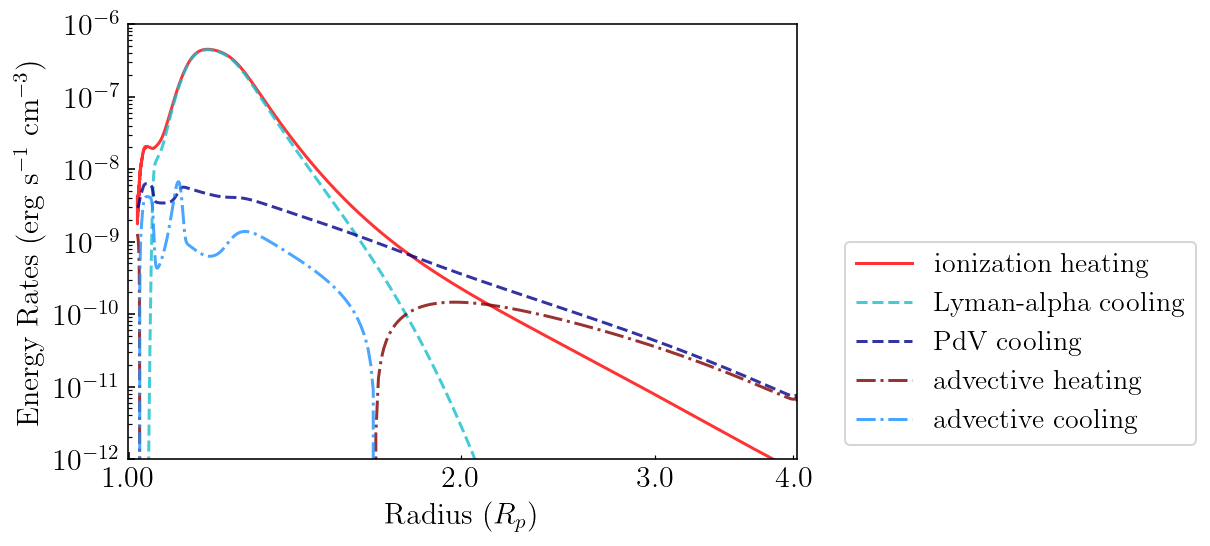

In [12]:
print(f"Mass loss rate is now {sim.windsoln.Mdot:.2e} g/s")
energy_plot(sim.windsoln)
#We can now see the photoionization heating is on par with PdV cooling below the base..

In [13]:
sim.save_planet('saves/HD189733b/HD189_13.6-2000eV_solar_10microbar_H-He.csv',
                polish=True,overwrite=True)

Polishing up boundary conditions...
Successfully ramped base boundary conditions.                                                           RHOSCALE (convergence condition) has changed from 100 to 1000. Remaking C code...
NOTE: Photoionization heating dominates down to base of sim (1.018 Rp). 
      Bolometric heat/cooling still turned off. Max error in dM/dt ~ 10%. 
       See documentation for workaround.
..Rmax 5.1557e+00, r_Cori 5.1659e+00                                                                                                                                                     
ERROR: Failed to integrate outwards to r_Cori: 5.166e+00 reverting back to 5.156e+00.
-
Polishing boundary conditions:
   Base boundary conditions:           Success
   Molec. to atomic transition:        Success
   Self-consist. Ncol at sonic point:  Success
   Setting Rmax to R_coriolis:         Failed
Saving saves/HD189733b/HD189_13.6-2000eV_solar_10microbar_H-He.csv


## 2. Ramping Stellar Spectrum <a id='spectrum'></a>         -           [Top](#top)
### Changing spectrum range <a id='range'></a>
`Fnorm` flux in units of ergs/s/cm2 at the planet in the range defined by `norm_spec_range`. Set the full range of your spectrum in `goal_spec_range`. If `Fnorm=0` (default), it will normalize to the current flux value in the norm_spec_range in your spectrum. If `goal_spec_range=[]` (default), it will maintain the same range bounds. 

In [2]:
# #If you are starting here, use Jupyter cell magic to load all of the relevant modules
# %run ../wrapper/imports.py
# %config InlineBackend.figure_format='retina'

In [10]:
sim = wind_sim()
sim.load_planet('saves/HD189733b/HD189733b_13.6-2000eV_solar_H-He.csv',
               print_atmo=False)
current_wl_range = sim.windsoln.spec_resolved
eV_range = (const.hc/current_wl_range) / const.eV
print(f"Current spectrum range is {current_wl_range}cm ([{eV_range[1]:.1f},{eV_range[0]:.1f}]eV)")

Current spectrum range is [6.19921274e-08 9.11648932e-06]cm ([13.6,2000.0]eV)


In [11]:
sim.ramp_spectrum(Fnorm=0,norm_spec_range=[13.6,100],
                  goal_spec_range=[10.3,2000],units='eV')

Spectrum will be normalized such that sum(Flux[12.40, 91.16]nm) = 21595 ergs/s/cm2.
Goal: [  0.61992127 120.37306285] nm
Ramped spectrum wavelength range, now normalizing spectrum. 
Ramping Ftot from 2.417e+04 to 3.196e+04.                                                                     
  Final:  Ftot:3.196176e+04, delta:0.1542                                                                      


0

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01


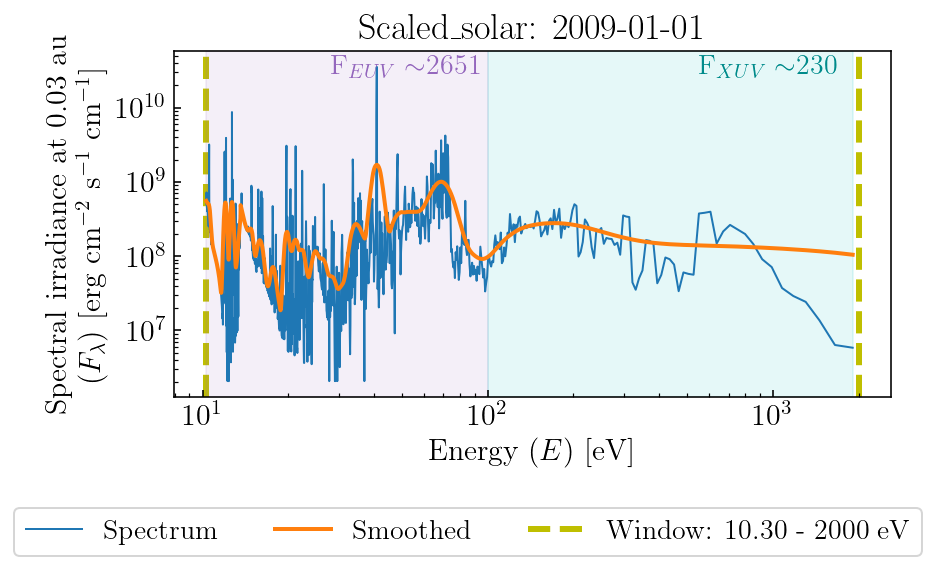

In [12]:
sim.load_planet('saves/windsoln.csv') 
#re-loading to update spectrum range for plotting purposes
sim.spectrum.plot(xaxis='energy',
                  semimajor_au=sim.windsoln.semimajor/const.au,
                  highlight_euv=True)
plt.show()

In [13]:
sim.save_planet('saves/HD189733b/HD189_10.3-2000eV_solar_H-He.csv',overwrite=True)

Saving saves/HD189733b/HD189_10.3-2000eV_solar_H-He.csv


### Ramping to custom spectrum <a id='custom'></a> -           [Top](#top)
Wind-AE includes an automatic smoothing and binning algorithm for spectra that ensures that the flux at the ionization energies for all of the species present in the simulation is accurate.

To ramp to a custom stellar spectrum first format your XUV spectrum using `format_user_spectrum()`. Once formatted, it will be stored in `McAstro/stars/spectrum/additional_spectra/` and will be accessed automatically by the code.

In [17]:
# Flux, NOT flux density
spectrum_data = pd.read_csv('External_spectra/HD189733b.dat',comment='#')
wl = spectrum_data['Wavelength']
flux_1au = spectrum_data['Flux']

sim = wind_sim()
sim.format_user_spectrum(wl = wl,
                         wl_units = 'cm',
                         flux_1au = flux_1au,
                         spectrum_name='hd189733',
                         comment='Spectrum for HD189733 (Bourrier et al. 2020)',
                         overwrite=True)

Spectrum saved in Wind-AE readable format at McAstro/stars/spectrum/additional_spectra/hd189733


 ...Ramping Ncol Iter 1: Current average diff 5.05e-01                                                          
Success ramping to hd189733 spectrum shape!


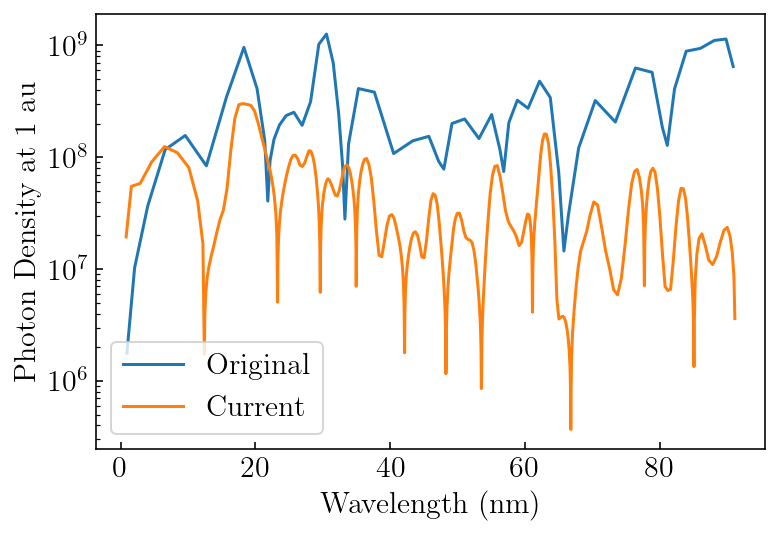

     Now ramping flux and spectral range.
Goal: [ 0.61992127 91.16489319] nm
Ramped spectrum wavelength range, now normalizing spectrum. 
 ..Fnorm = 17072 ergs/s/cm2. Norm range = [12.40,91.10]nm                                                     Flux ramping already done.
Success! Ramped to user-input stellar spectrum hd189733


0

In [3]:
#Est. runtime: 2 min
sim.load_planet('saves/HD189733b/HD189733b_13.6-2000eV_solar_H-He.csv',
               print_atmo=False)

sim.ramp_to_user_spectrum(spectrum_filename='hd189733',ramp_range=True)

In [4]:
sim.save_planet('saves/HD189733b/HD189_13.6-2000eV_actual_H-He.csv',
                polish=True,overwrite=True)

Polishing up boundary conditions...
Successfully converged Rmax to 5.554436 (Ncol also converged).                                                       Saving saves/HD189733b/HD189_13.6-2000eV_actual_H-He.csv            


## Metals - [Top](#top)
### Adding Metals <a id='metals'></a>
`Wind-AE`'s speed $\propto n_{species}$ so it is recommended to add metals last. If you are attempting to ramp far in parameter space, it may also be advisable to ramp with only H/He and add metals as a last step.

Future versions will include the ability to include multiple ionization states of the same element, but for now, select one ionization state per species.

This computation takes, on average, 10 minutes to add C I, N I, O I, Ne I, Mg II, Ca I.

If the ramper is having trouble ramping in metals, try raising the total column density (`sim.inputs.write_bcs(*sim.windsoln.bcs_tuple[0:5],sim.windsoln.Ncol_sp*5,sim.windsoln.bcs_tuple[-1])`+`sim.run_wind()`) or raising the stellar flux (`sim.ramp_Ftot(goal_F,converge_bcs=False)`).

In [2]:
sim = wind_sim()
sim.load_planet('saves/HD189733b/HD189_13.6-2000eV_actual_H-He.csv')

metals = ['CI','NI','OI','NeI','MgII','CaI','SiII']
#printing the mass fractions for Z metallicity 
sim.metallicity(metals,Z=1) #solar metallicities

Nspecies has changed from 9 to 2. Remaking C code...                                                                                      Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01


array([9.89320255e-01, 7.90297090e-04, 6.69189203e-03, 1.74756285e-03,
       6.47899249e-04, 6.35653783e-05, 7.38528061e-04])

In [7]:
#default, Z=1, but can ramp in with higher metallicity or using custom mass fractions
sim.add_metals(['CI','NI','OI','NeI','MgII','CaI','SiII'])

Avg. mass fraction diff from goal: 9.97e-02                                                                                               CI successfully added and ramped to mass fraction 2.29e-03. Now converging Ncol_sp.
Avg. mass fraction diff from goal: 9.99e-02                                                                                               NI successfully added and ramped to mass fraction 7.90e-04. Now converging Ncol_sp.
Avg. mass fraction diff from goal: 9.92e-02                                                                                               OI successfully added and ramped to mass fraction 6.69e-03. Now converging Ncol_sp.
Nspecies has changed from 5 to 6. Remaking C code...                                                                                      Failed to add new species. That shouldn't have happened. Raising Ncol_sp.
Avg. mass fraction diff from goal: 9.98e-02                                                                               

0

In [4]:
#Est. runtime: 30 minutes
sim.save_planet('saves/HD189733b/HD189_13.6-2000eV_actual_H-He-C-N-O-Ne-Mg-Ca-Si.csv',
               polish=True,overwrite=True)

Polishing up boundary conditions...
..Rmax 5.5544e+00, r_Cori 5.4904e+00                                                                                                                                                                                              Rmax done, but Ncol cannot be lowered to self-consistent value without introducing integration errors. Maximum error in Mdot in this case is 10 percent.
-
Polishing boundary conditions:
   Base boundary conditions:           Success
   Molec. to atomic transition:        Success
   Self-consist. Ncol at sonic point:  Success
   Setting Rmax to R_coriolis:         Failed
Saving saves/HD189733b/HD189_13.6-2000eV_actual_H-He-C-N-O-Ne-Mg-Ca-Si.csv


### Ramping Metallicity <a id='metallicity'></a>
Can ramp in units of Z$_{solar}$ or to a custom mass fraction array.

In [2]:
sim = wind_sim()
sim.load_planet('saves/HD189733b/HD189_13.6-2000eV_actual_H-He-C-N-O-Ne-Mg-Ca-Si.csv')

Atmosphere Composition
  Species:   HI,        HeI,        CI,        NI,        OI,        NeI,        MgII,        CaI,        SiII
  Mass frac: 7.87e-01, 2.00e-01, 2.29e-03, 7.90e-04, 6.69e-03, 1.75e-03, 6.48e-04, 6.36e-05, 7.39e-04


In [3]:
#Est. runtime: 2 hours
sim.ramp_metallicity(goal_Z=10,slow_ramp=True) 
#for this particular solution, slowly ramping in metallicity space is necessary

Starting metallicity: 1 xSolar
Successfully ramped base boundary conditions.                                                           Success! Ramped to goal metallicity, Z = 1 x Solar                                                                        
...Attempting Final Ncol Convergence. (Note: This is an estimate. Cannot converge precisely without outward integration).                                                              

In [6]:
#Est. runtime: 30 min (shorten by setting polish=False or running sim.polish_bcs(converge_Rmax=False))
sim.save_planet('saves/HD189733b/HD189_13.6-2000eV_solar_H-He-C-N-O-Ne-Mg-Ca-Si_10Z.csv',
               polish=True,overwrite=True)

Polishing up boundary conditions...
Successfully converged Rmax to 5.208837 (Ncol also converged).                                                       Saving saves/HD189733b/HD189_13.6-2000eV_solar_H-He-C-N-O-Ne-Mg-Ca-Si_10Z.csv


## 4. Saving in an easy output format <a id='output'></a> - [Top](#top)
Be nice to your collaborators and don't send them the complicated `Wind-AE` solution files. Instead, send csv with just the columns you care about.

In [7]:
sim.easy_output_file(outputs=['v','T','rho'],
                     output_file='saves/simplified_outputs/HD189_metals.dat',
                     comments='HD189733b w/ 10xZ_solar H,He,C,N,O,Ne,MgII,SiII,Ca. Actual HD189733 spectrum.')